In [1]:
import os
import sys

# Ensure that both driver and worker use the same Python executable
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
# starting spark session
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
spark =  SparkSession\
    .builder\
    .master('local[*]')\
    .appName('MLDistributed')\
    .getOrCreate()

sc = spark.sparkContext



24/09/12 18:58:47 WARN Utils: Your hostname, Helens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.14 instead (on interface en0)
24/09/12 18:58:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/12 18:58:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/12 18:58:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/12 18:58:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# reading data
from pyspark.sql.types import *
schema  = StructType(
    [   
        StructField('id', IntegerType(), False),
        StructField('JourneyCode', FloatType(), True),
        StructField('TravelTime', FloatType(), True),
        StructField('ArrivalDifference', FloatType(), True),
        StructField('DepartureDifference', FloatType(), True),
        StructField('HourOfDay', IntegerType(), True),
        StructField('ArrivalHour', IntegerType(), True),
        StructField('DepartureHour', IntegerType(), True),
        StructField('IsWeekend', IntegerType(), True),
        StructField('AvgTravelTimeByJourney', FloatType(), True),
    ]
)

In [5]:
#creating spark dataframe
df = spark.read.format('csv').option('header', 'true')\
                .schema(schema).load('./engineered_data.csv')


In [6]:
df.printSchema() #schema of the dataframe

root
 |-- id: integer (nullable = true)
 |-- JourneyCode: float (nullable = true)
 |-- TravelTime: float (nullable = true)
 |-- ArrivalDifference: float (nullable = true)
 |-- DepartureDifference: float (nullable = true)
 |-- HourOfDay: integer (nullable = true)
 |-- ArrivalHour: integer (nullable = true)
 |-- DepartureHour: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- AvgTravelTimeByJourney: float (nullable = true)



In [7]:

df.show()

+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
|  1|     1021.0|       9.3|            -0.15|              -9.45|        6|          6|            6|        0|                 5.575|
|  2|     1021.0|      1.85|              0.7|              -0.15|        6|          6|            6|        0|                 5.575|
|  3|     1053.0|       5.4|        1.0833334|         -4.3166666|        8|          8|            8|        0|                  3.85|
|  4|     1053.0|       2.3|        2.3833334|          1.0833334|        8|          8|            8|        0|                  3.85|
|  5|     1081.0|       0.0|            -7.55|  

In [8]:
#removing unnecessary columns to create attributes dataframes from extracted useful attributes in feature engineeering
df_features = df.drop('TravelTime').drop('HourOfDay').drop('DepartureHour').drop('ArrivalDifference').drop('DepartureDifference').drop('JourneyCode')
# .drop('id') # dropping the target variable and the other repititve features



In [9]:
df_features.columns

['id', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']

In [10]:
#creating the vector assembler
feature_cols = df_features.columns

# from pyspark.ml.feature import VectorAssembler
# assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=[col for col in df_features.columns if col != 'id'], 
    outputCol='features'
)

df_features_and_values = assembler.transform(df_features)

# dropping the rest of the column from the df_features dataframe after creating column with the feature_cols
df_features = df_features_and_values.drop('JourneyCode').drop('TravelTime').drop('ArrivalDifference').drop('DepartureDifference').drop('ArrivalHour').drop('IsWeekend').drop('AvgTravelTimeByJourney')

In [11]:
df_features.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[6.0,0.0,5.574999...|
|  2|[6.0,0.0,5.574999...|
|  3|[8.0,0.0,3.849999...|
|  4|[8.0,0.0,3.849999...|
|  5|[11.0,0.0,5.04166...|
|  6|[11.0,0.0,5.04166...|
|  7|    [13.0,0.0,5.375]|
|  8|    [13.0,0.0,5.375]|
|  9|[15.0,0.0,3.18333...|
| 10|[15.0,0.0,3.18333...|
| 11|[18.0,0.0,7.11666...|
| 12|[18.0,0.0,7.11666...|
| 13|[13.0,0.0,5.22499...|
| 14|[13.0,0.0,5.22499...|
| 15|[15.0,0.0,4.49166...|
| 16|[15.0,0.0,4.49166...|
| 17|[18.0,0.0,3.93333...|
| 18|[18.0,0.0,3.93333...|
| 19|[8.0,0.0,5.608333...|
| 20|[9.0,0.0,5.608333...|
+---+--------------------+
only showing top 20 rows



In [12]:
df_features_and_values.show()

+---+-----------+---------+----------------------+--------------------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|
+---+-----------+---------+----------------------+--------------------+
|  1|          6|        0|                 5.575|[6.0,0.0,5.574999...|
|  2|          6|        0|                 5.575|[6.0,0.0,5.574999...|
|  3|          8|        0|                  3.85|[8.0,0.0,3.849999...|
|  4|          8|        0|                  3.85|[8.0,0.0,3.849999...|
|  5|         11|        0|             5.0416665|[11.0,0.0,5.04166...|
|  6|         11|        0|             5.0416665|[11.0,0.0,5.04166...|
|  7|         13|        0|                 5.375|    [13.0,0.0,5.375]|
|  8|         13|        0|                 5.375|    [13.0,0.0,5.375]|
|  9|         15|        0|             3.1833334|[15.0,0.0,3.18333...|
| 10|         15|        0|             3.1833334|[15.0,0.0,3.18333...|
| 11|         18|        0|              7.116667|[18.0,0.0,7.11

In [13]:
print(feature_cols)

['id', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']


In [14]:
df_features.show()
df_features.count()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[6.0,0.0,5.574999...|
|  2|[6.0,0.0,5.574999...|
|  3|[8.0,0.0,3.849999...|
|  4|[8.0,0.0,3.849999...|
|  5|[11.0,0.0,5.04166...|
|  6|[11.0,0.0,5.04166...|
|  7|    [13.0,0.0,5.375]|
|  8|    [13.0,0.0,5.375]|
|  9|[15.0,0.0,3.18333...|
| 10|[15.0,0.0,3.18333...|
| 11|[18.0,0.0,7.11666...|
| 12|[18.0,0.0,7.11666...|
| 13|[13.0,0.0,5.22499...|
| 14|[13.0,0.0,5.22499...|
| 15|[15.0,0.0,4.49166...|
| 16|[15.0,0.0,4.49166...|
| 17|[18.0,0.0,3.93333...|
| 18|[18.0,0.0,3.93333...|
| 19|[8.0,0.0,5.608333...|
| 20|[9.0,0.0,5.608333...|
+---+--------------------+
only showing top 20 rows



24/09/12 18:59:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


1771

In [15]:
# scaling features
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

scaler_model =scaler.fit(df_features)

df_scaled = scaler_model.transform(df_features)

df_scaled.show(3, truncate=False)

+---+----------------------------+--------------------------------------------+
|id |features                    |scaled_features                             |
+---+----------------------------+--------------------------------------------+
|1  |[6.0,0.0,5.574999809265137] |[0.2608695652173913,0.0,0.470036086872814]  |
|2  |[6.0,0.0,5.574999809265137] |[0.2608695652173913,0.0,0.470036086872814]  |
|3  |[8.0,0.0,3.8499999046325684]|[0.34782608695652173,0.0,0.3205776104806935]|
+---+----------------------------+--------------------------------------------+
only showing top 3 rows



In [16]:
# renaming the scaled_features as features
df_scaled = df_scaled.drop('features')
df_scaled = df_scaled.withColumnRenamed('scaled_features', 'features')

df_scaled.show(3, truncate=False)

+---+--------------------------------------------+
|id |features                                    |
+---+--------------------------------------------+
|1  |[0.2608695652173913,0.0,0.470036086872814]  |
|2  |[0.2608695652173913,0.0,0.470036086872814]  |
|3  |[0.34782608695652173,0.0,0.3205776104806935]|
+---+--------------------------------------------+
only showing top 3 rows



In [17]:
df_scaled.printSchema()

root
 |-- id: integer (nullable = true)
 |-- features: vector (nullable = true)



In [18]:
#caching data to prepare for multiple iterations
df_features_only = df_scaled.drop('id')
df_features_only.cache()

DataFrame[features: vector]

In [19]:
#using the underlying rdd of the dataframe we already normalised
data_rdd = df_features_only.rdd.map(lambda row: row['features']).cache() #collecting dataframe to the driver using map to take the vector inside Row Type

#maintaininng centroids in the driver 

# Using takeSample function to randomly sampling the RDD
k=3
centroids = data_rdd.takeSample(False, k, 123456)
centroids


[DenseVector([0.7391, 0.0, 0.1388]),
 DenseVector([0.0, 0.0, 0.0204]),
 DenseVector([0.4783, 0.0, 0.129])]

In [20]:
# converting centroids to numply arrays
centroids =np.array(centroids)

#broadcasting centroid to all workers to make accessible 
centroids_bc = sc.broadcast(centroids)

In [21]:
def dist(a, b, axis=1):
    return np.sqrt(np.sum((a - b)**2, axis=axis)) #axis calculates distance between each row or between two matrices


In [22]:
#calculating the closest centroid for each element of the rdd.

#function that takes instance and returns the index of the nearest centroid

def nearest_centroid(vect):
    return np.argmin(dist(centroids_bc.value, vect))


In [23]:
# data_rdd.map(lambda vect: nearest_centroid(vect)).take(10)

In [24]:
#obtaining nearest centroid and instance pair, and elements of data that belong to the same centroid

closest = data_rdd.map(lambda p: (nearest_centroid(p), (1, p)))


In [25]:
#using reduceByKey to aggregrate both elements of each example in that cluster and the total of elements
new_centroids_rdd = closest.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))

In [26]:
#computing centroids by dividing the aggregrated values by the count
new_centroids = new_centroids_rdd.map(lambda x: x[1][1]/x[1][0]).collect()

np.array(new_centroids)

array([[0.41684877, 0.03812825, 0.1640545 ],
       [0.68960886, 0.        , 0.17974455],
       [0.        , 0.        , 0.03156324]])

In [27]:
#creating a function that incoporates the process
def mapReduce_distributed_kmeans(rdd, k, threshold=0.001, seed=12345):
    #fix random seed
    np.random.seed
    #randomly choose k samples from the training data
    centroids = data_rdd.takeSample(False, k, 123456)
    #convert into np arrays
    centroids =np.array(centroids)
    converged = False
    while not converged:
        #broadcast the current centroids 
        centroids_bc = sc.broadcast(centroids)

        #assigning each exapme to the nearest center
        closest = data_rdd.map(lambda p: (nearest_centroid(p), (1, p)))

        #creating new centroids 
        new_centroids_rdd = closest.reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))

        #collecting the aggregrated centroids to be converted to np arrays
        new_centroids = new_centroids_rdd.map(lambda x: x[1][1]/x[1][0]).collect()

        new_centroids = np.array(new_centroids)

        # checking if converged 
        #compute difference between current and previous
        diff = dist(new_centroids, centroids, axis =None) #computing difference between the new centroids and the old ones

        if diff < threshold:
            converged = True
        else:
            centroids = new_centroids
    return centroids, closest

    

In [28]:
#obtaining centroids choosing 3 clusters based on selection from sihoulette score
k=3
centroids, c = mapReduce_distributed_kmeans(data_rdd, k)
centroids

array([[0.41684877, 0.03812825, 0.1640545 ],
       [0.68960886, 0.        , 0.17974455],
       [0.        , 0.        , 0.03156324]])

In [29]:
#testing for efficiency of the process.
k=3
%time centroids, c = mapReduce_distributed_kmeans(data_rdd, k)

CPU times: user 30.5 ms, sys: 11.2 ms, total: 41.7 ms
Wall time: 1.2 s


To add the predictions of clusters from the distributed K-Means process back into the original DataFrame that contains all your features

In [30]:

# Using the distributed K-Means function to get centroids and cluster assignments
k = 3
centroids, cluster_assignments_rdd = mapReduce_distributed_kmeans(data_rdd, k)

# Each element of cluster_assignments_rdd is now (cluster_index, (1, point_vector))
# using this to extract the cluster assignments

# Extracting (point_index, cluster_index) pairs for joining back with original DataFrame

cluster_assignments = cluster_assignments_rdd.map(lambda x: (x[0], x[1][1])).zipWithIndex().map(lambda x: (x[1], x[0][0]))

# Converting cluster assignments RDD to DataFrame

# Creating a schema for the DataFrame
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("cluster", IntegerType(), True)
])


#converting the original DataFrame into an RDD with an index
df_with_index = df_features_and_values.rdd.zipWithIndex().map(lambda x: (x[1], x[0]))

# Joining the two RDDs on the index
df_with_clusters_rdd = df_with_index.join(cluster_assignments)

# Converting the resulting RDD to a DataFrame
df_with_clusters = df_with_clusters_rdd.map(lambda x: (x[1][0]['id'], int(x[1][1]))).toDF(schema)

# Step 3: Join the clusters DataFrame with the original DataFrame

# Join on the 'id' column
df_final = df_features_and_values.join(df_with_clusters, on='id')

# Show the final DataFrame with features and cluster assignments
df_final.show(truncate=False)


+---+-----------+---------+----------------------+----------------------------+-------+
|id |ArrivalHour|IsWeekend|AvgTravelTimeByJourney|features                    |cluster|
+---+-----------+---------+----------------------+----------------------------+-------+
|1  |6          |0        |5.575                 |[6.0,0.0,5.574999809265137] |2      |
|3  |8          |0        |3.85                  |[8.0,0.0,3.8499999046325684]|2      |
|5  |11         |0        |5.0416665             |[11.0,0.0,5.041666507720947]|2      |
|7  |13         |0        |5.375                 |[13.0,0.0,5.375]            |2      |
|9  |15         |0        |3.1833334             |[15.0,0.0,3.183333396911621]|0      |
|11 |18         |0        |7.116667              |[18.0,0.0,7.116666793823242]|0      |
|13 |13         |0        |5.225                 |[13.0,0.0,5.224999904632568]|2      |
|15 |15         |0        |4.491667              |[15.0,0.0,4.491666793823242]|0      |
|17 |18         |0        |3.933

Visualizing the feature pairs with predicted clusters.

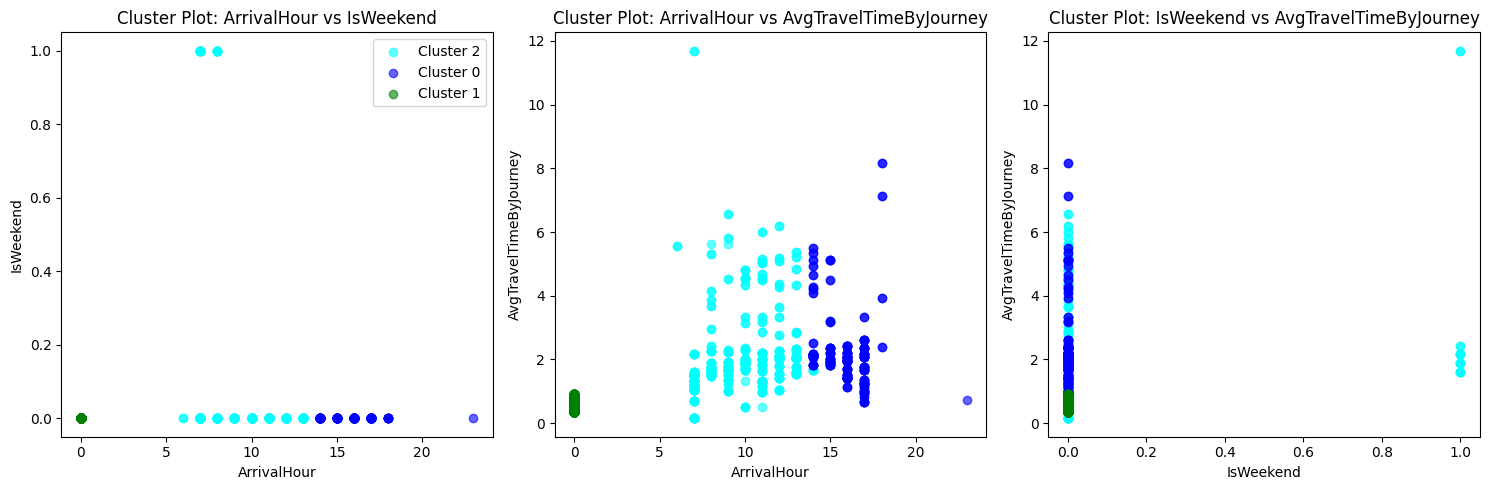

In [31]:
import matplotlib.pyplot as plt
from itertools import combinations

# Convert your Spark DataFrame to Pandas for easier plotting
pandas_df = df_final.select(
     'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney',  'cluster'
).toPandas()

# Define a color map for the clusters
colors = ['blue', 'green', 'cyan', 'purple', 'orange']  # Adjust the number of colors to match the number of clusters

# List of features to plot in pairs
features = ['ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']

# Set the number of rows and columns for the grid layout
n_cols = 3  # Number of plots in each row
n_rows = (len(list(combinations(features, 2))) + n_cols - 1) // n_cols  # Dynamically calculate rows

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through each pair of features using combinations
for idx, feature_pair in enumerate(combinations(features, 2)):
    
    ax = axes[idx]  # Get the current axis
    # Plot each cluster in a different color
    for cluster in pandas_df['cluster'].unique():
        data = pandas_df[pandas_df['cluster'] == cluster]
        ax.scatter(data[feature_pair[0]], data[feature_pair[1]], 
                   c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)
    
    # Adding title and labels
    ax.set_title(f'Cluster Plot: {feature_pair[0]} vs {feature_pair[1]}')
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])
    
    # Adding a legend only for the first subplot
    if idx == 0:
        ax.legend()

# Hide any remaining empty subplots (if any)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the grid of plots
plt.show()


In [32]:
df_final.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|  935|
|      2|  577|
|      0|  259|
+-------+-----+



In [33]:
df_final.show()

+---+-----------+---------+----------------------+--------------------+-------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster|
+---+-----------+---------+----------------------+--------------------+-------+
|  1|          6|        0|                 5.575|[6.0,0.0,5.574999...|      2|
|  3|          8|        0|                  3.85|[8.0,0.0,3.849999...|      2|
|  5|         11|        0|             5.0416665|[11.0,0.0,5.04166...|      2|
|  7|         13|        0|                 5.375|    [13.0,0.0,5.375]|      2|
|  9|         15|        0|             3.1833334|[15.0,0.0,3.18333...|      0|
| 11|         18|        0|              7.116667|[18.0,0.0,7.11666...|      0|
| 13|         13|        0|                 5.225|[13.0,0.0,5.22499...|      2|
| 15|         15|        0|              4.491667|[15.0,0.0,4.49166...|      0|
| 17|         18|        0|             3.9333334|[18.0,0.0,3.93333...|      0|
| 19|          8|        0|             

In [34]:

from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Evaluate the clustering performance on test data
silhouette_score_test = evaluator.evaluate(df_final)

print(f'Silhouette Score for Train Data: {silhouette_score_test}')


24/09/12 18:59:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/12 18:59:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Silhouette Score for Train Data: 0.8400969663749458


In [35]:
# # Perform the join to add the 'TravelTime' column back into df_with_clusters
train_df_final = df_final.join(df.select("id", "TravelTime"), on="id", how="inner")
train_df_final.show()


+---+-----------+---------+----------------------+--------------------+-------+----------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster|TravelTime|
+---+-----------+---------+----------------------+--------------------+-------+----------+
|  1|          6|        0|                 5.575|[6.0,0.0,5.574999...|      2|       9.3|
|  3|          8|        0|                  3.85|[8.0,0.0,3.849999...|      2|       5.4|
|  5|         11|        0|             5.0416665|[11.0,0.0,5.04166...|      2|       0.0|
|  7|         13|        0|                 5.375|    [13.0,0.0,5.375]|      2|  9.416667|
|  9|         15|        0|             3.1833334|[15.0,0.0,3.18333...|      0|  4.516667|
| 11|         18|        0|              7.116667|[18.0,0.0,7.11666...|      0| 12.616667|
| 13|         13|        0|                 5.225|[13.0,0.0,5.22499...|      2|  9.933333|
| 15|         15|        0|              4.491667|[15.0,0.0,4.49166...|      0|  8.566667|

In [36]:
# Select the 'TravelTime' column and get distinct values
unique_travel_times = train_df_final.select("TravelTime").distinct()

# Show the unique values
unique_travel_times.show(truncate=False)

+----------+
|TravelTime|
+----------+
|5.85      |
|1.8666667 |
|2.6666667 |
|8.333333  |
|7.4333334 |
|0.56666666|
|7.7166667 |
|4.95      |
|0.78333336|
|7.05      |
|3.3333333 |
|0.6333333 |
|2.3666666 |
|5.5       |
|1.8166667 |
|2.5       |
|2.7833333 |
|1.9666667 |
|5.6833334 |
|0.73333335|
+----------+
only showing top 20 rows



In [37]:
train_df_final.show()

+---+-----------+---------+----------------------+--------------------+-------+----------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster|TravelTime|
+---+-----------+---------+----------------------+--------------------+-------+----------+
|  1|          6|        0|                 5.575|[6.0,0.0,5.574999...|      2|       9.3|
|  3|          8|        0|                  3.85|[8.0,0.0,3.849999...|      2|       5.4|
|  5|         11|        0|             5.0416665|[11.0,0.0,5.04166...|      2|       0.0|
|  7|         13|        0|                 5.375|    [13.0,0.0,5.375]|      2|  9.416667|
|  9|         15|        0|             3.1833334|[15.0,0.0,3.18333...|      0|  4.516667|
| 11|         18|        0|              7.116667|[18.0,0.0,7.11666...|      0| 12.616667|
| 13|         13|        0|                 5.225|[13.0,0.0,5.22499...|      2|  9.933333|
| 15|         15|        0|              4.491667|[15.0,0.0,4.49166...|      0|  8.566667|

Kmeans and ANN prediction on test data

In [38]:
# reading data schema
from pyspark.sql.types import *
schema  = StructType(
    [   
        StructField('id', IntegerType(), False),
        StructField('JourneyCode', FloatType(), True),
        StructField('TravelTime', FloatType(), True),
        StructField('ArrivalDifference', FloatType(), True),
        StructField('DepartureDifference', FloatType(), True),
        StructField('HourOfDay', IntegerType(), True),
        StructField('ArrivalHour', IntegerType(), True),
        StructField('DepartureHour', IntegerType(), True),
        StructField('IsWeekend', IntegerType(), True),
        StructField('AvgTravelTimeByJourney', FloatType(), True),
    ]
)

#fetching test data feature engineering stage.
test_df = spark.read.format('csv').option('header', 'true')\
                .schema(schema).load('./Updated_test_data.csv')

In [39]:
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- JourneyCode: float (nullable = true)
 |-- TravelTime: float (nullable = true)
 |-- ArrivalDifference: float (nullable = true)
 |-- DepartureDifference: float (nullable = true)
 |-- HourOfDay: integer (nullable = true)
 |-- ArrivalHour: integer (nullable = true)
 |-- DepartureHour: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- AvgTravelTimeByJourney: float (nullable = true)



In [40]:
test_df.show()

+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
|  1|     1053.0|       3.2|              1.8|               -1.4|        8|          8|            8|        0|             2.6083333|
|  2|     1053.0| 2.0166667|        2.8166666|                1.8|        8|          8|            8|        0|             2.6083333|
|  3|     1081.0|  4.383333|       0.53333336|              -3.85|       11|         11|           11|        0|             2.5583334|
|  4|     1081.0|0.73333335|       0.26666668|         0.53333336|       11|         11|           11|        0|             2.5583334|
|  5|     1109.0|       9.7|        3.8666666|  

In [41]:
#removing unnecessary columns to create attributes dataframes from extracted useful attributes in feature engineeering
test_df_features = test_df.drop('TravelTime').drop('HourOfDay').drop('DepartureHour').drop('ArrivalDifference').drop('DepartureDifference').drop('JourneyCode')
# dropping the target variable and the other repititve features


In [42]:
test_df_features.columns

['id', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']

In [43]:
#creating the vector assembler
test_feature_cols = test_df_features.columns

In [44]:
from pyspark.ml.feature import VectorAssembler
test_assembler = VectorAssembler(
    inputCols=[col for col in test_df_features.columns if col != 'id'], 
    outputCol='features'
)

test_df_features_and_values = test_assembler.transform(test_df_features)

# dropping the rest of the column from the df_features dataframe after creating column with the feature_cols
test_df_features = test_df_features_and_values.drop('JourneyCode').drop('TravelTime').drop('ArrivalDifference').drop('DepartureDifference').drop('ArrivalHour').drop('IsWeekend').drop('AvgTravelTimeByJourney')

In [45]:
test_df_features_and_values.columns
test_df_features.columns
test_df_features.show()
test_df_features.count()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[8.0,0.0,2.608333...|
|  2|[8.0,0.0,2.608333...|
|  3|[11.0,0.0,2.55833...|
|  4|[11.0,0.0,2.55833...|
|  5|[13.0,0.0,5.47499...|
|  6|[13.0,0.0,5.47499...|
|  7|      [16.0,0.0,0.5]|
|  8|      [16.0,0.0,0.5]|
|  9|[18.0,0.0,3.39166...|
| 10|[18.0,0.0,3.39166...|
| 11|[8.0,0.0,3.166666...|
| 12|[8.0,0.0,3.166666...|
| 13|[11.0,0.0,4.55833...|
| 14|[11.0,0.0,4.55833...|
| 15|     [12.0,1.0,0.25]|
| 16|[11.0,0.0,3.15833...|
| 17|[11.0,0.0,3.15833...|
| 18|[13.0,0.0,1.55833...|
| 19|[13.0,0.0,1.55833...|
| 20|[16.0,0.0,1.11249...|
+---+--------------------+
only showing top 20 rows



992

In [46]:
from pyspark.ml.feature import MinMaxScaler
test_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

scaler_model =test_scaler.fit(test_df_features)

test_df_scaled = scaler_model.transform(test_df_features)

test_df_scaled.show(3, truncate=False)

+---+----------------------------+--------------------------------------------+
|id |features                    |scaled_features                             |
+---+----------------------------+--------------------------------------------+
|1  |[8.0,0.0,2.6083333492279053]|[0.4444444444444444,0.0,0.08675659447392786]|
|2  |[8.0,0.0,2.6083333492279053]|[0.4444444444444444,0.0,0.08675659447392786]|
|3  |[11.0,0.0,2.558333396911621]|[0.611111111111111,0.0,0.08491723381346832] |
+---+----------------------------+--------------------------------------------+
only showing top 3 rows



In [47]:
test_df_scaled = test_df_scaled.drop('features')
test_df_scaled = test_df_scaled.withColumnRenamed('scaled_features', 'features')

test_df_scaled.show(3, truncate=False)

+---+--------------------------------------------+
|id |features                                    |
+---+--------------------------------------------+
|1  |[0.4444444444444444,0.0,0.08675659447392786]|
|2  |[0.4444444444444444,0.0,0.08675659447392786]|
|3  |[0.611111111111111,0.0,0.08491723381346832] |
+---+--------------------------------------------+
only showing top 3 rows



In [48]:
test_df_scaled.printSchema()

root
 |-- id: integer (nullable = true)
 |-- features: vector (nullable = true)



In [49]:
# Function to calculate the nearest centroid for a test data point
def nearest_centroid_test(point, centroids):
    distances = np.linalg.norm(centroids - np.array(point), axis=1)  # Calculate Euclidean distances to each centroid
    return int(np.argmin(distances))  # Return the index of the nearest centroid

# Broadcast the trained centroids
centroids_bc = sc.broadcast(centroids)

# Predict the cluster for test data
test_predictions_rdd = test_df_scaled.rdd.map(lambda row: (row['id'], nearest_centroid_test(row['features'], centroids_bc.value)))

# Define schema for the predictions DataFrame
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("predicted_cluster", IntegerType(), True)
])

# Convert RDD to DataFrame
test_predictions_df = test_predictions_rdd.toDF(schema)

# Join the predicted clusters back to the original test DataFrame to see the results
test_df_with_predictions = test_df_scaled.join(test_predictions_df, on='id')

# Show the test data with predicted clusters
test_df_with_predictions.show(truncate=False)
test_df_values_features_clusters = test_df_features_and_values.join(test_predictions_df, on='id')
test_df_values_features_clusters.show()


+---+---------------------------------------------+-----------------+
|id |features                                     |predicted_cluster|
+---+---------------------------------------------+-----------------+
|1  |[0.4444444444444444,0.0,0.08675659447392786] |0                |
|2  |[0.4444444444444444,0.0,0.08675659447392786] |0                |
|3  |[0.611111111111111,0.0,0.08491723381346832]  |1                |
|4  |[0.611111111111111,0.0,0.08491723381346832]  |1                |
|5  |[0.7222222222222222,0.0,0.1922133688186729]  |1                |
|6  |[0.7222222222222222,0.0,0.1922133688186729]  |1                |
|7  |[0.8888888888888888,0.0,0.009196812073061162]|1                |
|8  |[0.8888888888888888,0.0,0.009196812073061162]|1                |
|9  |[1.0,0.0,0.1155732711334177]                 |1                |
|10 |[1.0,0.0,0.1155732711334177]                 |1                |
|11 |[0.4444444444444444,0.0,0.10729614377596804] |0                |
|12 |[0.444444444444

+---+-----------+---------+----------------------+--------------------+-----------------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|predicted_cluster|
+---+-----------+---------+----------------------+--------------------+-----------------+
|  1|          8|        0|             2.6083333|[8.0,0.0,2.608333...|                0|
|  2|          8|        0|             2.6083333|[8.0,0.0,2.608333...|                0|
|  3|         11|        0|             2.5583334|[11.0,0.0,2.55833...|                1|
|  4|         11|        0|             2.5583334|[11.0,0.0,2.55833...|                1|
|  5|         13|        0|                 5.475|[13.0,0.0,5.47499...|                1|
|  6|         13|        0|                 5.475|[13.0,0.0,5.47499...|                1|
|  7|         16|        0|                   0.5|      [16.0,0.0,0.5]|                1|
|  8|         16|        0|                   0.5|      [16.0,0.0,0.5]|                1|
|  9|     

Visualizing the feature pairs with predicted clusters.

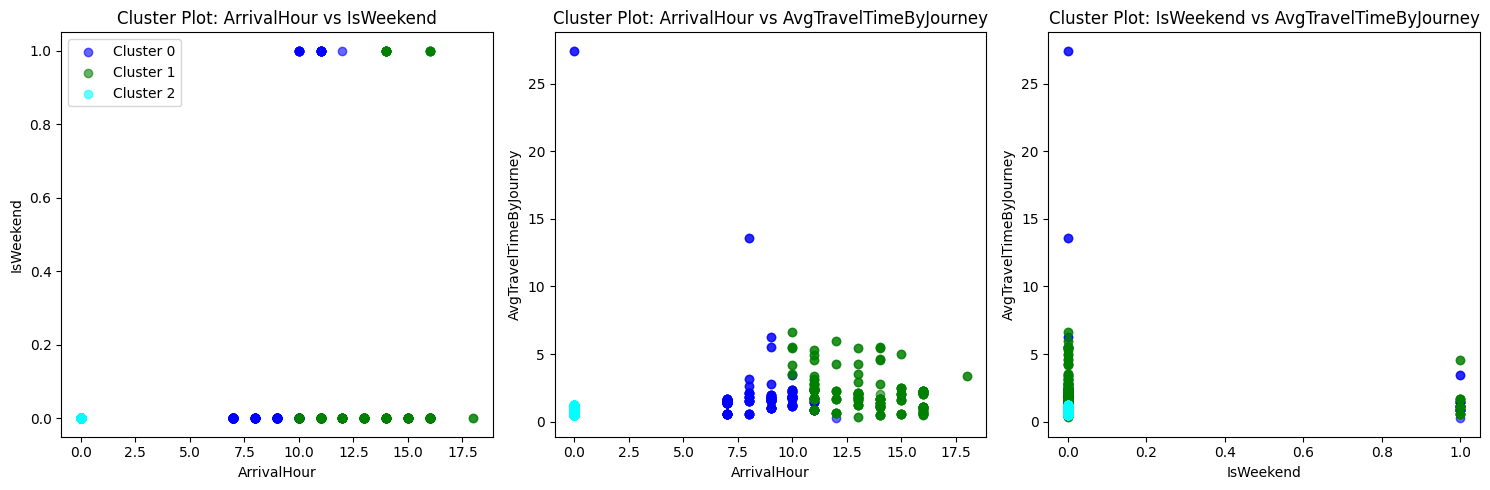

In [50]:

from itertools import combinations
# Number of rows and columns for the grid layout (adjust as needed)
n_cols = 3  # Number of plots in each row
n_rows = (len(list(combinations(features, 2))) + n_cols - 1) // n_cols  # Calculate rows dynamically

# Convert your Spark DataFrame to Pandas for easier plotting
test_pandas_df = test_df_values_features_clusters.select(
    'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney', 'predicted_cluster'
).toPandas()

# Define a color map for the clusters
colors = ['blue', 'green', 'cyan', 'purple', 'orange']  # Adjust the number of colors to match the number of clusters

# List of features to plot in pairs
features = ['ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through each pair of features using combinations
for idx, feature_pair in enumerate(combinations(features, 2)):
    
    ax = axes[idx]  # Get the current axis
    # Plot each cluster in a different color
    for cluster in test_pandas_df['predicted_cluster'].unique():
        data = test_pandas_df[test_pandas_df['predicted_cluster'] == cluster]
        ax.scatter(data[feature_pair[0]], data[feature_pair[1]], 
                   c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)
    
    # Adding title and labels
    ax.set_title(f'Cluster Plot: {feature_pair[0]} vs {feature_pair[1]}')
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])
    
    # Adding a legend only for the first subplot
    if idx == 0:
        ax.legend()

# Hide any remaining empty subplots (if any)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the grid of plots
plt.show()

In [51]:
test_df_values_features_clusters.groupby('predicted_cluster').count().show()


+-----------------+-----+
|predicted_cluster|count|
+-----------------+-----+
|                1|  269|
|                2|  478|
|                0|  245|
+-----------------+-----+



In [52]:
#evaluating cluster of test set with sihoulette score.
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='predicted_cluster', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Evaluate the clustering performance on test data
silhouette_score_test = evaluator.evaluate(test_df_values_features_clusters)

print(f'Silhouette Score for Test Data: {silhouette_score_test}')


Silhouette Score for Test Data: 0.7913597840773668


In [53]:
#adding travel time for prepartation for prediction
test_df_values_features_target = test_df_values_features_clusters.join(test_df.select('id', 'TravelTime'), on ='id', how = 'inner')
test_df_values_features_target.show()

+---+-----------+---------+----------------------+--------------------+-----------------+----------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|predicted_cluster|TravelTime|
+---+-----------+---------+----------------------+--------------------+-----------------+----------+
|  1|          8|        0|             2.6083333|[8.0,0.0,2.608333...|                0|       3.2|
|  2|          8|        0|             2.6083333|[8.0,0.0,2.608333...|                0| 2.0166667|
|  3|         11|        0|             2.5583334|[11.0,0.0,2.55833...|                1|  4.383333|
|  4|         11|        0|             2.5583334|[11.0,0.0,2.55833...|                1|0.73333335|
|  5|         13|        0|                 5.475|[13.0,0.0,5.47499...|                1|       9.7|
|  6|         13|        0|                 5.475|[13.0,0.0,5.47499...|                1|      1.25|
|  7|         16|        0|                   0.5|      [16.0,0.0,0.5]|                1|  

In [54]:
from pyspark.sql import functions as F
#obtain range for classification
# Calculate and print the minimum and maximum TravelTime in the training dataset
min_max_train = train_df_final.agg(
    F.min('TravelTime').alias('min_travel_time'),
    F.max('TravelTime').alias('max_travel_time')
)

# Display the min and max travel times for the training dataset
min_max_train.show()

# Calculate and print the minimum and maximum TravelTime in the test dataset
min_max_test = test_df_values_features_target.agg(
    F.min('TravelTime').alias('min_travel_time'),
    F.max('TravelTime').alias('max_travel_time')
)

# Display the min and max travel times for the test dataset
min_max_test.show()


+---------------+---------------+
|min_travel_time|max_travel_time|
+---------------+---------------+
|            0.0|      23.383333|
+---------------+---------------+

+---------------+---------------+
|min_travel_time|max_travel_time|
+---------------+---------------+
|            0.0|      27.433332|
+---------------+---------------+



Define bins for the TravelTime in both train and test data

In [55]:
train_df_final.show()

+---+-----------+---------+----------------------+--------------------+-------+----------+
| id|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster|TravelTime|
+---+-----------+---------+----------------------+--------------------+-------+----------+
|  1|          6|        0|                 5.575|[6.0,0.0,5.574999...|      2|       9.3|
|  3|          8|        0|                  3.85|[8.0,0.0,3.849999...|      2|       5.4|
|  5|         11|        0|             5.0416665|[11.0,0.0,5.04166...|      2|       0.0|
|  7|         13|        0|                 5.375|    [13.0,0.0,5.375]|      2|  9.416667|
|  9|         15|        0|             3.1833334|[15.0,0.0,3.18333...|      0|  4.516667|
| 11|         18|        0|              7.116667|[18.0,0.0,7.11666...|      0| 12.616667|
| 13|         13|        0|                 5.225|[13.0,0.0,5.22499...|      2|  9.933333|
| 15|         15|        0|              4.491667|[15.0,0.0,4.49166...|      0|  8.566667|

In [56]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Define bins for the TravelTime in both train and test data

# Bin TravelTime in the training data
train_df_with_clusters_and_features = train_df_final.withColumn(
    'binned_travel_time',
    when(col('TravelTime') == 0, 'Zero') 
    .when((col('TravelTime') > 0) & (col('TravelTime') < 5), 'Low')
    .when((col('TravelTime') >= 5) & (col('TravelTime') < 10), 'Moderate')
    .when((col('TravelTime') >= 10) & (col('TravelTime') < 15), 'High')
    .otherwise('Very High')
)

# Bin TravelTime in the test data
test_df_with_clusters_and_features = test_df_values_features_target.withColumn(
    'binned_travel_time', 
    when(col('TravelTime') == 0, 'Zero') 
    .when((col('TravelTime') > 0) & (col('TravelTime') < 5), 'Low')
    .when((col('TravelTime') >= 5) & (col('TravelTime') < 10), 'Moderate')
    .when((col('TravelTime') >= 10) & (col('TravelTime') < 15), 'High')
    .otherwise('Very High')
)

# Convert the binned travel time to numeric labels in training and test data
train_df_with_clusters_and_features = train_df_with_clusters_and_features.withColumn(
    'binned_travel_time_numeric', 
    when(col('binned_travel_time') == 'Zero', 0) 
    .when(col('binned_travel_time') == 'Low', 1)
    .when(col('binned_travel_time') == 'Moderate', 2)
    .when(col('binned_travel_time') == 'High', 3)
    .when(col('binned_travel_time') == 'Very High', 4)
)

test_df_with_clusters_and_features = test_df_with_clusters_and_features.withColumn(
    'binned_travel_time_numeric', 
     when(col('binned_travel_time') == 'Zero', 0) 
    .when(col('binned_travel_time') == 'Low', 1)
    .when(col('binned_travel_time') == 'Moderate', 2)
    .when(col('binned_travel_time') == 'High', 3)
    .when(col('binned_travel_time') == 'Very High', 4)
)

# Train ANN model for each cluster

# Empty list to hold predictions for all clusters
all_predictions = []

for cluster_num in range(3):  # for 3 clusters
    print(f"Training ANN model for Cluster {cluster_num}")
    
    # Filter data for the current cluster
    train_df_cluster = train_df_with_clusters_and_features.filter(col("cluster") == cluster_num)
    test_df_cluster = test_df_with_clusters_and_features.filter(col("predicted_cluster") == cluster_num)

    # Drop unnecessary columns in training data
    train_data = train_df_cluster.drop('binned_travel_time', 'cluster')

    # Drop unnecessary columns in test data
    test_data = test_df_cluster.drop('binned_travel_time')

    # Define the ANN structure and train the model
    layers = [3, 5, 5, 5]  # 6 input neurons, 5 in hidden layers, 4 output neurons for 4 classes
    ann = MultilayerPerceptronClassifier(featuresCol="features", labelCol="binned_travel_time_numeric", maxIter=100, layers=layers, blockSize=128, seed=1234)
    
    # Fit the model on the training data
    ann_model = ann.fit(train_data)

    # Make Predictions on the test data
    cluster_predictions = ann_model.transform(test_data)
    
    # Add the cluster number for visualization
    cluster_predictions = cluster_predictions.withColumn('predicted_cluster', F.lit(cluster_num))
    
    # Collect predictions for all clusters
    all_predictions.append(cluster_predictions)

    # Evaluate the model for accuracy, precision, and F1 score
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="f1")
    
    accuracy = evaluator_accuracy.evaluate(cluster_predictions)
    precision = evaluator_precision.evaluate(cluster_predictions)
    f1_score = evaluator_f1.evaluate(cluster_predictions)
    
    # Print the evaluation metrics
    print(f"Cluster {cluster_num} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    print("-" * 40)

# Combine all cluster predictions into a single DataFrame (if needed for further analysis)
combined_predictions = all_predictions[0]
for cluster_pred in all_predictions[1:]:
    combined_predictions = combined_predictions.union(cluster_pred)



Training ANN model for Cluster 0


24/09/12 18:59:38 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/09/12 18:59:38 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/09/12 18:59:38 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
24/09/12 18:59:38 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.0625


Cluster 0 Evaluation Metrics:
Accuracy: 0.49795918367346936
Precision: 0.2541451435345923
F1 Score: 0.3365328549002018
----------------------------------------
Training ANN model for Cluster 1


24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
24/09/12 18:59:47 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.09375
24/09/12 18:59:47 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed


Cluster 1 Evaluation Metrics:
Accuracy: 0.4163568773234201
Precision: 0.40075112559822956
F1 Score: 0.3840957658226369
----------------------------------------
Training ANN model for Cluster 2
Cluster 2 Evaluation Metrics:
Accuracy: 0.07531380753138076
Precision: 0.005672169604873864
F1 Score: 0.010549794051088354
----------------------------------------


Processing Cluster 0


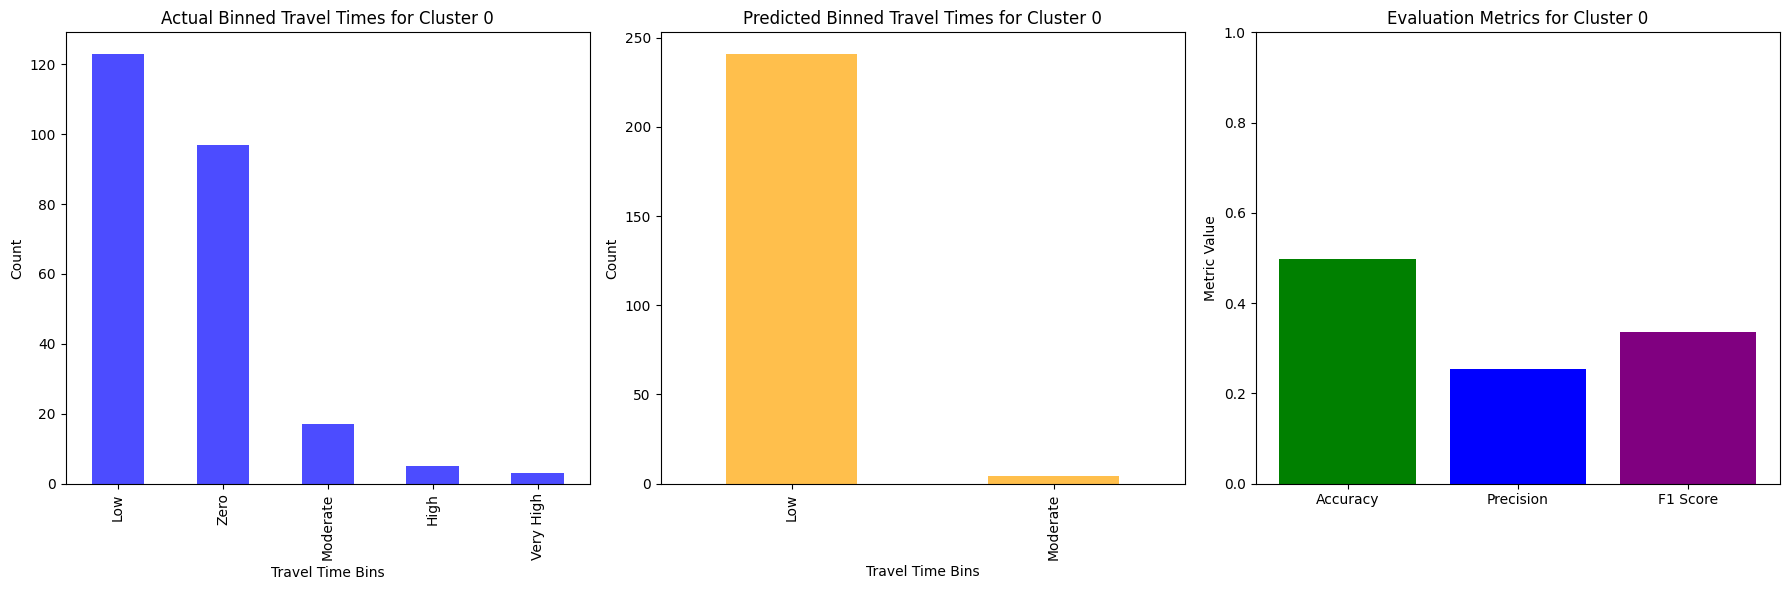

Processing Cluster 1


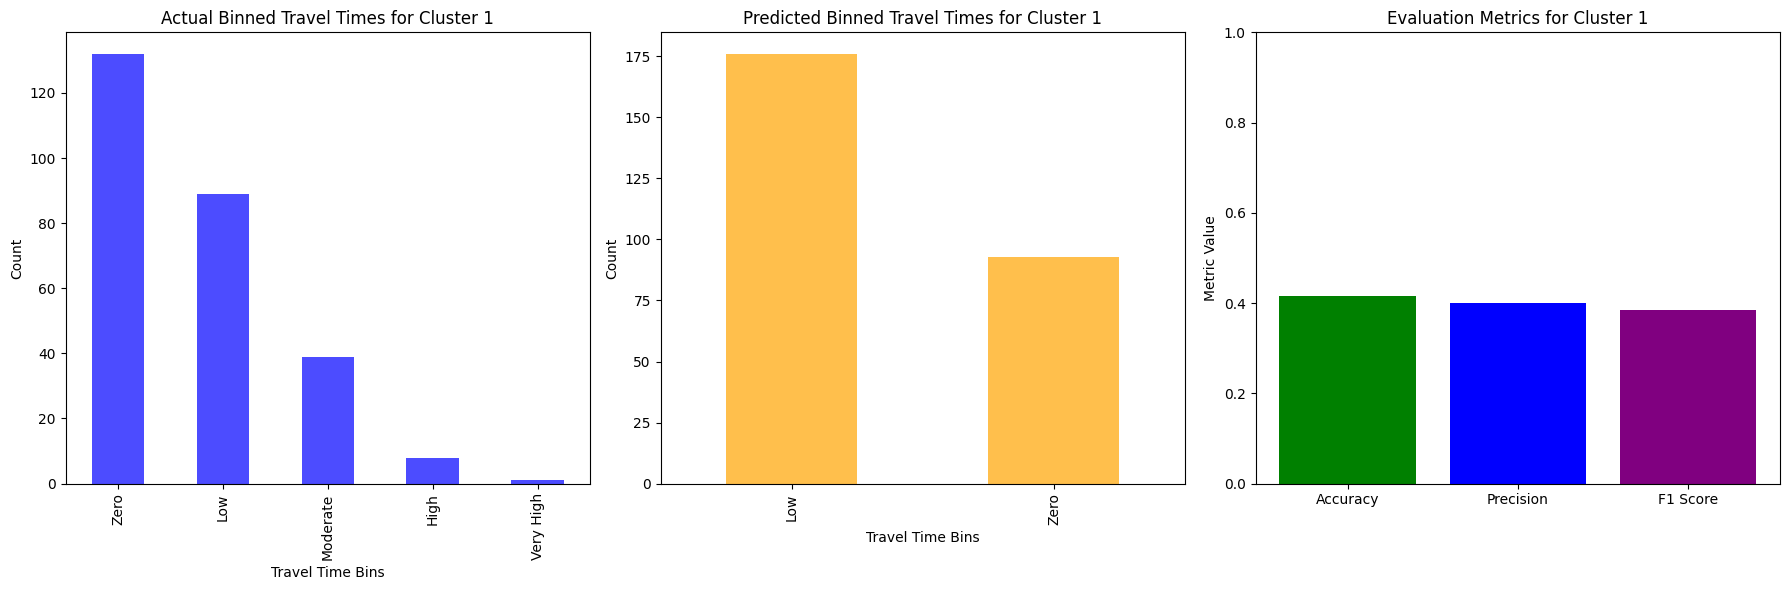

Processing Cluster 2


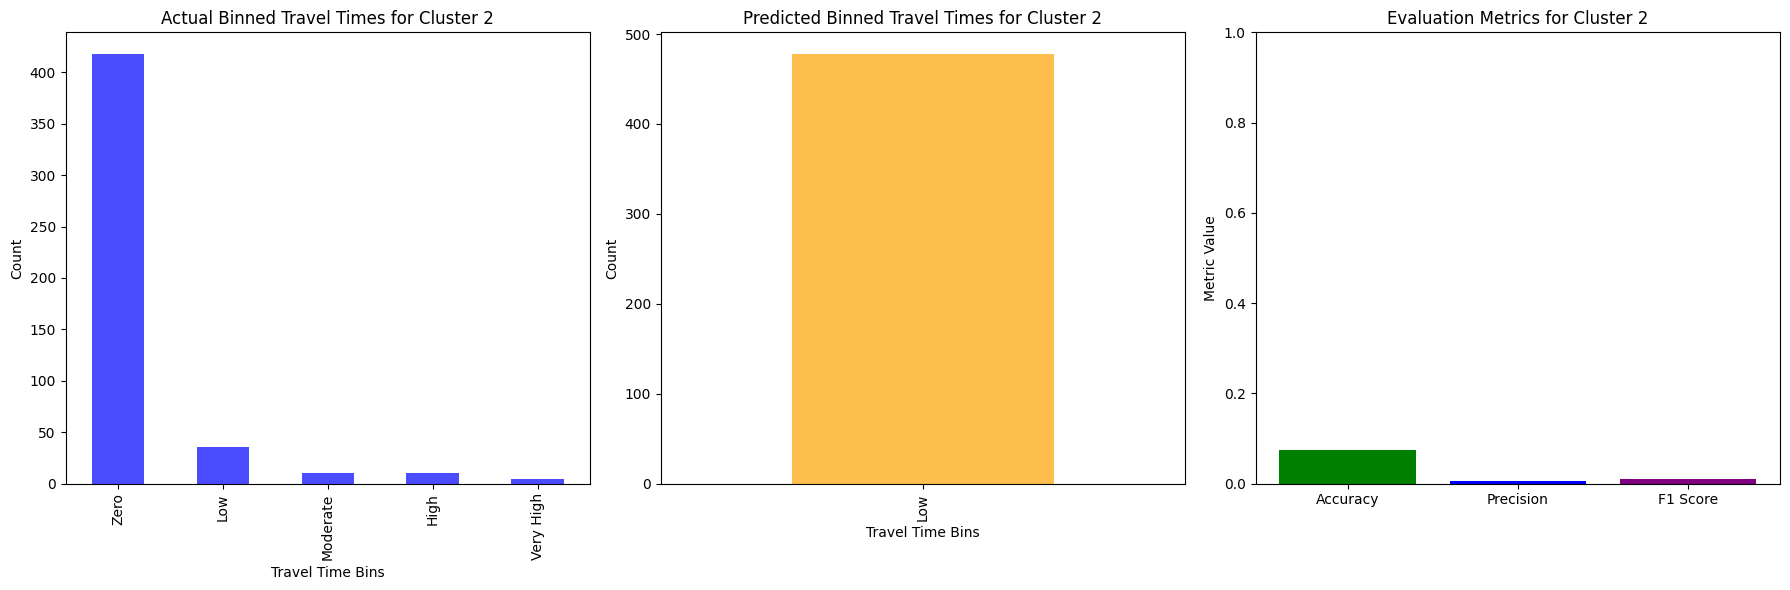

Cluster 0 Metrics:
  Accuracy: 0.49795918367346936
  Precision: 0.2541451435345923
  F1 Score: 0.3365328549002018
----------------------------------------
Cluster 1 Metrics:
  Accuracy: 0.4163568773234201
  Precision: 0.40075112559822956
  F1 Score: 0.3840957658226369
----------------------------------------
Cluster 2 Metrics:
  Accuracy: 0.07531380753138076
  Precision: 0.005672169604873864
  F1 Score: 0.010549794051088354
----------------------------------------


In [57]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Define the evaluator objects for accuracy, precision, and F1 score
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="weightedPrecision")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="f1")

# Initialize empty lists to hold evaluation metrics for all clusters
cluster_metrics = []

# Iterate through each cluster for evaluation and visualization
for cluster_num in range(3):  # for 3 clusters
    print(f"Processing Cluster {cluster_num}")
    
    # Filter predictions for the current cluster
    cluster_data = combined_predictions.filter(F.col("predicted_cluster") == cluster_num)
    
    # Evaluate the metrics using PySpark DataFrame
    accuracy = evaluator_accuracy.evaluate(cluster_data)
    precision = evaluator_precision.evaluate(cluster_data)
    f1_score = evaluator_f1.evaluate(cluster_data)
    
    # Save metrics for each cluster to display them later
    cluster_metrics.append((cluster_num, accuracy, precision, f1_score))
    
    # Convert to Pandas for plotting
    cluster_data_pandas = cluster_data.select('binned_travel_time_numeric', 'prediction').toPandas()

    # Map numeric bins back to categorical bins for easier visualization
    bin_mapping = {0: 'Zero', 1: 'Low', 2: 'Moderate', 3: 'High', 4: 'Very High'}
    cluster_data_pandas['actual_bins'] = cluster_data_pandas['binned_travel_time_numeric'].map(bin_mapping)
    cluster_data_pandas['predicted_bins'] = cluster_data_pandas['prediction'].map(bin_mapping)

    # Create the plot
    plt.figure(figsize=(18, 6))

    # Plot Actual Binned Travel Times
    plt.subplot(1, 3, 1)
    cluster_data_pandas['actual_bins'].value_counts().plot(kind='bar', color='blue', alpha=0.7)
    plt.title(f'Actual Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    # Plot Predicted Binned Travel Times
    plt.subplot(1, 3, 2)
    cluster_data_pandas['predicted_bins'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Predicted Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    # Display evaluation metrics in a separate subplot
    plt.subplot(1, 3, 3)
    plt.bar(['Accuracy', 'Precision', 'F1 Score'], [accuracy, precision, f1_score], color=['green', 'blue', 'purple'])
    plt.ylim(0, 1)  # Metrics are usually between 0 and 1
    plt.title(f'Evaluation Metrics for Cluster {cluster_num}')
    plt.ylabel('Metric Value')

    # Display the plots
    plt.tight_layout()
    plt.show()

#  print out the metrics for all clusters
for cluster_num, accuracy, precision, f1_score in cluster_metrics:
    print(f"Cluster {cluster_num} Metrics:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  F1 Score: {f1_score}")
    print("-" * 40)


In [ ]:
combined_predictions.to_csv('./combined_predictions.csv', index=False)